### Bayesian Data Analysis, 3rd ed
##  Chapter 3, demo 6

Illustrate posterior inference for Bioassay data (BDA3 p. 74-).

#### Instructions for exercise (3.11 in BDA3)
- Check that the range and spacing of A and B are sensible for the 
  alternative prior
- Compute the log-posterior in a grid
- Scale the log-posterior by subtracting its maximum value before
  exponentiating (think why this is useful)
- Exponentiate
- Normalize the posterior
- Use 2D grid sampling 
- In addition to the plots, report p(beta>0|x,y)

In [2]:
import numpy as np
from scipy.special import expit  # aka logistic

%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
import os, sys
# add utilities directory to path
util_path = os.path.abspath(os.path.join(os.path.pardir, 'utilities_and_data'))
if util_path not in sys.path and os.path.exists(util_path):
    sys.path.insert(0, util_path)

# import from utilities
import plot_tools

In [4]:
# edit default plot settings
plt.rc('font', size=12)
# apply custom background plotting style
plt.style.use(plot_tools.custom_styles['gray_background'])

In [5]:
# seed a random state
rng = np.random.RandomState(0)

## Bioassay Example
The following examples seeks to determine if a particular drug increases the mortality rate in rats.

The experiment has been designed so that the 20 rats have been split into 4 groups of 5. Each group will recieve a particular dose of the 'medicine' and the number of deaths within each group will be monitored.

Note: Its conventional for the dose of medicine to be in log(amount), rather than just amount. (This explains the negative units).

In [1]:
# data
x = np.array([-0.86, -0.30, -0.05, 0.73])    # log-dose
n = np.array([5, 5, 5, 5]) # number of rats in group
y = np.array([0, 1, 3, 5]) # number of deaths

NameError: name 'np' is not defined

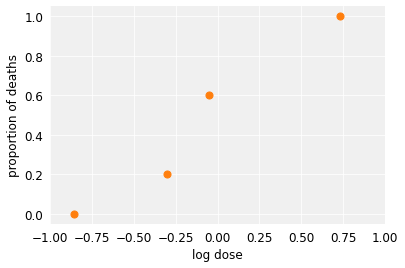

In [7]:
# plot the data
plt.scatter(x, y/n, 50, color='C1')
plt.xlim((-1, 1))
plt.xlabel('log dose')
plt.ylabel('proportion of deaths');

A quick review of the data shows that there is _some_ relationship between dose and death rate, we can see there are no deaths on the low dose, and 100% death on the high dose with two 'transition' doses in between.

We need to be more rigourous than just making casual observations. Clearly we don't have that many data points so our confidence levels need to reflect the lack of data

## Logistic Regression

Logistic regression is a statistical model that in its basic form uses a logistic function to model a binary dependent variable. This is ideally suited to our case, as we have a continuous variable (log-dose) being used to predict a categorical variable (death).

The output of logistic regression can be interpreted as 'probability of being dead'

### Form of the logistic regression equation

The simplest model of the dose–response relation—that is, the relation of θ i to x i —is
linear: θ i = α + βx i . Unfortunately, this model has the flaw that at low or high doses,
x i approaches ±∞ (recall that the dose is measured on the log scale), whereas θ i , being a
probability, must be constrained to lie between 0 and 1. The standard solution is to use a
transformation of the θ’s, such as the logistic, in the dose–response relation:

logit(θ) = α + βx,

where logit(θ) = log(θ /(1 − θ)). This is called a logistic regression
model.

The two parameters that define the logistic regression model are *alpha* and *beta*, and its the distribution of these parameters that we'll be calculating

## JP Notes

This next process is going to follow two steps

For each A and B we are going to calculate the inverse logit. i.e calculate the probability of death at a given dose level. This is our prior (we haven't seen the data yet)

Then we use the binomial model to ask ourselves the question (for each A,B combination):
If this A,B is true, what is the probability of seeing the number of deaths I actually observed? (This is our likelihood)


Question:

The evaluation of each logistic regression model, given the data does not include the binomial coefficient (N choose k). Is this an oversight? does it matter?

In [11]:
#A quick plot showing the logit function for some example inputs

# The A and B values are just moving the logit function around, we then take a point on from the dose data
from math import comb

A2=1
B2=10

#data
x2 = 0.86    # log dose
n2 = 5     # number of participants
y2 = 3     # number of deaths

inverse_logit_p = 1 / (np.exp(-(A2 + B2 * x2)) + 1)
print(f' probability of death from model - {inverse_logit_p}')

# Then, given that A,B Logit model, evaluate how probable it is
p = comb(n,y)*(inverse_logit_p**y2 * (1 - inverse_logit_p)**(n2 - y))

print(f'Probability of observing that many deaths, given the logistic model {p}')

 probability of death from model - 0.9999322758503804


TypeError: only integer scalar arrays can be converted to a scalar index

In [25]:
# compute the posterior density in grid
#  - usually should be computed in logarithms!
#  - with alternative prior, check that range and spacing of A and B
#    are sensible
A = np.linspace(-4, 8, 100)
B = np.linspace(-10, 40, 100)
ilogit_abx = 1 / (np.exp(-(A[:,None] + B[:,None,None] * x)) + 1)
p = np.prod(ilogit_abx**y * (1 - ilogit_abx)**(n - y), axis=2)

## JP Edits

Its unclear what this interaction between the grid, and the later sampling method. It looks like in setting up the grid, we are calculating our joint probabaility distribution all in one go.

This is an artificial help, which wouldn't be present in a normal problem

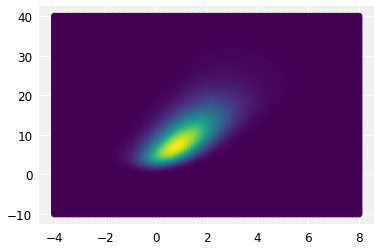

In [26]:
xv,yv = np.meshgrid(A,B)
xv = xv.flatten()
yv = yv.flatten()
plt.scatter(xv,yv,c=p)

In [27]:
# sample from the grid
nsamp = 1000
samp_indices = np.unravel_index(
    rng.choice(p.size, size=nsamp, p=p.ravel()/np.sum(p)),
    p.shape
)
samp_A = A[samp_indices[1]]
samp_B = B[samp_indices[0]]
# add random jitter, see BDA3 p. 76
samp_A += (rng.rand(nsamp) - 0.5) * (A[1]-A[0])
samp_B += (rng.rand(nsamp) - 0.5) * (B[1]-B[0])

# samples of LD50 conditional beta > 0
bpi = samp_B > 0
samp_ld50 = -samp_A[bpi]/samp_B[bpi]

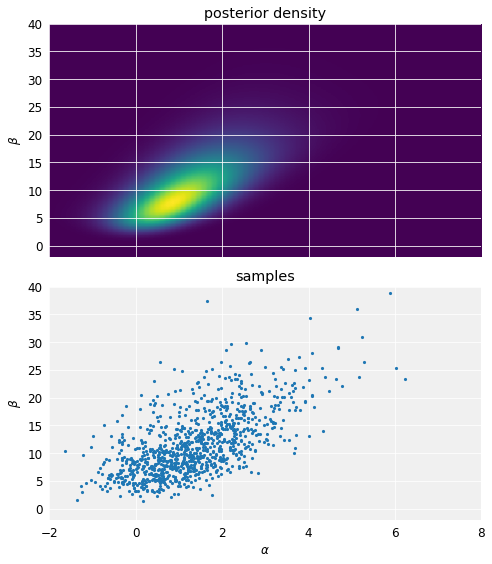

In [28]:
# create figure
fig, axes = plt.subplots(2, 1, figsize=(7, 8), sharex=True)

# plot the posterior density
ax = axes[0]
ax.imshow(p, origin='lower', aspect='auto', extent=(A[0], A[-1], B[0], B[-1]))
ax.set_xlim([-2,8])
ax.set_ylim([-2,40])
ax.set_ylabel(r'$\beta$')
ax.grid('off')
ax.set_title('posterior density')

# plot the samples
ax = axes[1]
ax.scatter(samp_A, samp_B, 10, linewidth=0)
ax.set_xlim([-2,8])
ax.set_ylim([-2,40])
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$\beta$')
ax.set_title('samples')

fig.tight_layout()

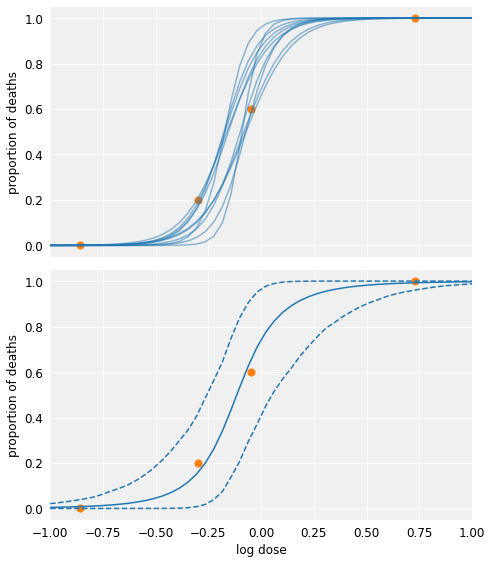

In [31]:
# plot samples with the data
xt = np.linspace(-1, 1)
fs = expit(samp_A[:, None] + samp_B[:, None]*xt)

# ceate figure
fig, axes = plt.subplots(2, 1, figsize=(7, 8), sharex=True)

# plot 10 first samples
ax = axes[0]
ax.plot(xt, fs[:10].T, color='C0', alpha=0.5)
ax.scatter(x, y/n, 50, color='C1')
ax.set_xlim((-1, 1))
ax.set_ylabel('proportion of deaths')

# plot mean and [5% 95%] interval
ax = axes[1]
ax.plot(xt, np.mean(fs, axis=0).T, color='C0')
ax.plot(
    xt,
    np.percentile(fs, [5, 95], axis=0).T,
    color='C0',
    linestyle='--'
)
ax.scatter(x, y/n, 50, color='C1')
ax.set_xlim((-1, 1))
ax.set_xlabel('log dose')
ax.set_ylabel('proportion of deaths')

fig.tight_layout()

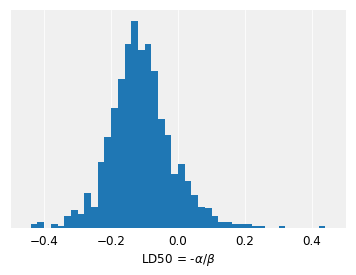

In [11]:
# plot the histogram of LD50
plt.hist(samp_ld50, np.arange(-0.5, 0.51, 0.02))
plt.xlim([-0.5, 0.5])
plt.xlabel(r'LD50 = -$\alpha/\beta$')
plt.yticks(());